In [1]:
"""
Braille Character Recognition - Image Classification Using CNN
-----------------------------------------------------------------

This notebook demonstrates how to build a deep learning model to classify 
Braille characters (A–Z) using grayscale image data. The dataset consists of 
2,600 PNG images categorized into 26 classes, with 100 samples per letter.

Each Braille character is represented as a 2D image of raised dot patterns. 
Our objective is to accurately map these patterns to their corresponding 
alphabet labels using a CNN-based classifier in PyTorch.

Key Steps:
- Loading and transforming image data from labeled folders
- Visualizing sample images
- Training a CNN for classification
- Evaluating model performance with accuracy and F1-score
- Plotting training/validation metrics

Dataset Format:
- Structure: Root/Label_Name/Image.png
- Total Images: 2,600 across 26 folders (A-Z)

Libraries Used:
- PyTorch for model definition and training
- Torchvision for data transformations and loading
- Matplotlib & Seaborn for visualizations
- Scikit-learn for evaluation metrics
"""

# 📦 Import Required Libraries

# Standard imports
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset

# Sklearn for metrics
from sklearn.metrics import accuracy_score, f1_score

# ⚠️ Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

## Dataset Overview
📝 Braille Character Dataset                                                
📦 Total Classes: 26 (A to Z)                                               
🖼️ Images per class: 100                                                    
📊 Total Images: 2,600                                                      
📁 Each folder represents one Braille character (A-Z) with PNG images.

## Custom Dataset and Dataloaders

In [2]:
class BrailleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # A-Z folders
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.endswith('.png'):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Image transformations: resize and normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),            # Ensure single-channel grayscale
    transforms.Resize((64, 64)),       # Resize images to 64x64
    transforms.ToTensor(),             # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # normalize grayscale image
])

# Load dataset using ImageFolder (auto-labels folders)
dataset = datasets.ImageFolder(root="/kaggle/input/braille-character-image-classification/Braille Alphabet Image Dataset (A–Z)" , transform=transform)

# Split dataset: 80% train, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Batch image tensor shape: torch.Size([32, 1, 64, 64])
Batch label shape: torch.Size([32])


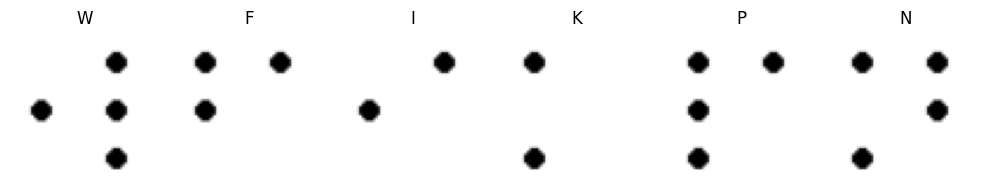

In [4]:
# Preview one batch
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)  # Should be [32, 1, 64, 64]
print("Batch label shape:", labels.shape)         # Should be [32]

# Visualize few samples
def show_batch(img_batch, label_batch):
    plt.figure(figsize=(10, 3))
    for i in range(6):
        img = img_batch[i].squeeze(0)  # remove channel dim
        plt.subplot(1, 6, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(chr(label_batch[i].item() + 65))  # Convert label to letter
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_batch(images, labels)

# Model Training and Evaluation

In [5]:
class BrailleCNN(nn.Module):
    def __init__(self):
        super(BrailleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: (1, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Output: (32, 32, 32)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Output: (64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)                              # Output: (128, 8, 8)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 26)  # 26 classes (A-Z)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrailleCNN().to(device)

# Cross-entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
# Store history for plotting
train_losses, val_losses = [], []
val_accuracies, val_f1s = [], []

def train_model(epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"✅ Epoch {epoch+1} - Train Loss: {avg_loss:.4f}")

        val_loss, val_acc, val_f1 = evaluate_model()
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

def evaluate_model():
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"📊 Validation Loss: {avg_val_loss:.4f} | Accuracy: {accuracy*100:.2f}% | F1 Score: {f1:.4f}")
    return avg_val_loss, accuracy, f1


In [8]:
def plot_metrics():
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, val_accuracies, label="Val Accuracy", color='green')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, val_f1s, label="Val F1 Score", color='orange')
    plt.title("Validation F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    plt.show()


Epoch 1/10: 100%|██████████| 65/65 [00:20<00:00,  3.14it/s, loss=0.0227]


✅ Epoch 1 - Train Loss: 0.7746
📊 Validation Loss: 0.0052 | Accuracy: 100.00% | F1 Score: 1.0000


Epoch 2/10: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s, loss=0.0136]


✅ Epoch 2 - Train Loss: 0.0224
📊 Validation Loss: 0.0004 | Accuracy: 100.00% | F1 Score: 1.0000


Epoch 3/10: 100%|██████████| 65/65 [00:17<00:00,  3.74it/s, loss=0.0189]


✅ Epoch 3 - Train Loss: 0.0092
📊 Validation Loss: 0.0001 | Accuracy: 100.00% | F1 Score: 1.0000


Epoch 4/10: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s, loss=0.00392]


✅ Epoch 4 - Train Loss: 0.0054
📊 Validation Loss: 0.0001 | Accuracy: 100.00% | F1 Score: 1.0000


Epoch 5/10: 100%|██████████| 65/65 [00:15<00:00,  4.07it/s, loss=0.00106]


✅ Epoch 5 - Train Loss: 0.0051
📊 Validation Loss: 0.0000 | Accuracy: 100.00% | F1 Score: 1.0000


Epoch 6/10: 100%|██████████| 65/65 [00:16<00:00,  3.98it/s, loss=0.0652]


✅ Epoch 6 - Train Loss: 0.0122
📊 Validation Loss: 0.0002 | Accuracy: 100.00% | F1 Score: 1.0000


Epoch 7/10: 100%|██████████| 65/65 [00:14<00:00,  4.36it/s, loss=0.00212]


✅ Epoch 7 - Train Loss: 0.0131
📊 Validation Loss: 0.0001 | Accuracy: 100.00% | F1 Score: 1.0000


Epoch 8/10: 100%|██████████| 65/65 [00:15<00:00,  4.20it/s, loss=0.00406]


✅ Epoch 8 - Train Loss: 0.0032
📊 Validation Loss: 0.0000 | Accuracy: 100.00% | F1 Score: 1.0000


Epoch 9/10: 100%|██████████| 65/65 [00:15<00:00,  4.20it/s, loss=7.81e-5]


✅ Epoch 9 - Train Loss: 0.0022
📊 Validation Loss: 0.0000 | Accuracy: 100.00% | F1 Score: 1.0000


Epoch 10/10: 100%|██████████| 65/65 [00:15<00:00,  4.09it/s, loss=0.000166]


✅ Epoch 10 - Train Loss: 0.0013
📊 Validation Loss: 0.0000 | Accuracy: 100.00% | F1 Score: 1.0000


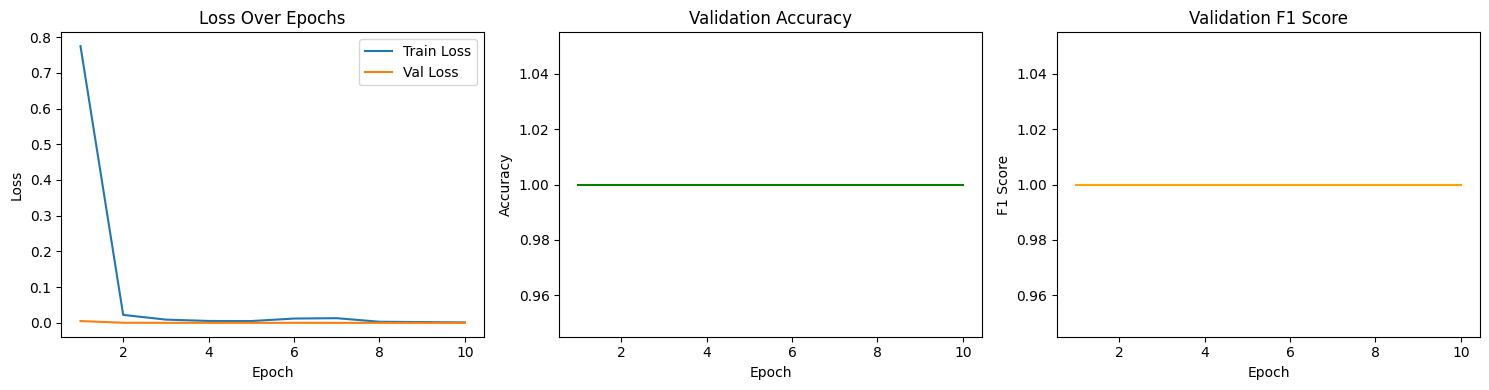

In [9]:
train_model(epochs=10)
plot_metrics()

🙏 **Thank You!**

If you found this notebook helpful or insightful, please consider upvoting!  
Your support motivates me to keep sharing meaningful content with the community.

Best of luck with your machine learning journey, and stay secure! 
